# SSD Train

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time
import pickle
import random

from ssd.ssd import SSD, Detector, UpSample, DownSample
from ssd.ssd_loss import MultiboxLoss
from ssd.ssd_bbox import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### load data

In [3]:
# some constants
NUM_CLASSES = 2 # remember the background 
input_shape = (384, 384, 3)

In [7]:
"""
tf.reset_default_graph()
## priorbox defined by ourselves
prior_tensor = tf.ones((1, 300, 300, 3))
ssd_net = SSD(input_shape, NUM_CLASSES)
_, priors = ssd_net(prior_tensor, PRIORS = True)
print(priors.shape)
"""

(?, 7308, 8)


In [17]:
# DEBUG by tensorboard

g = tf.Graph()
with g.as_default():
    #a = tf.placeholder(tf.float32, name="a")
    #b = tf.placeholder(tf.float32, name="b")
    #c = a + b
    ## priorbox defined by ourselves
    input_tensor = tf.ones((1, 300, 300, 3))
    ssd_net = SSD()
    feats = ssd_net(input_tensor)
    detect_net = Detector(input_shape, NUM_CLASSES)
    priors = detect_net(feats, PRIORS=True)
    print(priors.shape)
    
tf.summary.FileWriter("logs", g).close()

(?, 6498, 8)


In [14]:
with g.as_default():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        priors_np = sess.run(priors)

# save priors tensor
with open('./data/priors384.pkl', 'wb') as handle:
    pickle.dump(np.squeeze(priors_np), handle)

In [4]:
# load priors tensor
with open('./data/priors384.pkl', 'rb') as handle:
    priors_np = pickle.load(handle)
    print(priors_np.shape)

(10368, 8)


### bbox

In [5]:
#sess = tf.InteractiveSession()
#sess.run(tf.global_variables_initializer())
#priors_np = np.squeeze(sess.run(priors))
bbox_util = BBoxUtility(NUM_CLASSES, priors_np)

In [6]:
print([None,] + list(priors_np.shape))

[None, 10368, 8]


### data

In [78]:
## bounding box ground truth
gt = pickle.load(open('./data/indata.pkl', 'rb'))
keys = sorted(gt.keys())
random.shuffle(keys)
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)
print(num_train)
print(num_val)

333
83


In [13]:
from ssd.preprocess import *
## input images
## define input data generator: return a batch of input images as well as target feature vectors 
## like 64587, 8+num_classes
path_prefix = './data/train/'

# batch_size = 4
gen = Generator(gt, bbox_util, 4, './data/train/',
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

Using TensorFlow backend.


### new data

In [7]:
path_prefixs = ['./data/0247img/', './data/0249img/', './data/0251img/', './data/0254img/']

In [8]:
gt = dict()
train_keys = dict()
val_keys = dict(())
num_train = 0
num_val = 0
for path in path_prefixs:
    file = path.replace("img/", ".pkl")
    ## bounding box ground truth
    gt[path] = dict(pickle.load(open(file, 'rb')))
    #keys = list(gt.keys())
    keys = sorted(gt[path].keys())
    tmp_num_train = int(round(0.8 * len(keys)))
    print(tmp_num_train, "/", len(keys))
    num_train += tmp_num_train
    train_keys[path] = keys[:tmp_num_train]
    val_keys[path] = keys[tmp_num_train:]
    num_val += len(val_keys[path])
print(num_train)
print(num_val)

23 / 29
26 / 32
54 / 68
58 / 72
161
40


In [9]:
from ssd.preprocess import *
## input images
## define input data generator: return a batch of input images as well as target feature vectors 
## like 64587, 8+num_classes
#path_prefix = './data/0254img/'

# batch_size = 4
gen = Generator(gt, bbox_util, 4, path_prefixs,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

Using TensorFlow backend.


### build model

In [11]:
batch_size = 4

In [12]:
tf.reset_default_graph()
input_ph = tf.placeholder(tf.float32, [None,] + list(input_shape), name="input_image")
gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 4+NUM_CLASSES+priors_np.shape[1]], name="ground_truth")
with tf.variable_scope("ssd_net"):
    ssd_net = SSD()
    feats = ssd_net(input_ph)
    
with tf.variable_scope("detector"):
    detector = Detector(input_shape, NUM_CLASSES)
    predictions = detector(feats, PRIORS=False)
    
with tf.variable_scope("loss"):
    loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(gt_ph, predictions)
    
with tf.variable_scope("train"):
    global_step = tf.Variable(0, trainable=False)
    lr = tf.train.exponential_decay(3e-4, global_step, num_train//batch_size, 0.9, staircase=True, name="lr")
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### train

In [13]:
train_generator = gen.generate(True)
val_generator = gen.generate(False)

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [15]:
saver = tf.train.Saver()

In [11]:
# load model
saver.restore(sess, "/models/ssd_2.ckpt")
print("Model restored.")

INFO:tensorflow:Restoring parameters from /models/ssd_2.ckpt


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /models/ssd_2.ckpt: Not found: /models; No such file or directory
	 [[Node: save/RestoreV2_22 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_22/tensor_names, save/RestoreV2_22/shape_and_slices)]]
	 [[Node: save/RestoreV2_47/_189 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_452_save/RestoreV2_47", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save/RestoreV2_22', defined at:
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-a5e717b04428>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on /models/ssd_2.ckpt: Not found: /models; No such file or directory
	 [[Node: save/RestoreV2_22 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_22/tensor_names, save/RestoreV2_22/shape_and_slices)]]
	 [[Node: save/RestoreV2_47/_189 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_452_save/RestoreV2_47", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [16]:
train_loss_hist = []
nb_epoch = 40
for e in range(nb_epoch):
    # training phase
    cnt = 0
    for sample in train_generator:
        _, train_input, train_target = sample
        train_loss, _ = sess.run([loss, train_op], feed_dict={input_ph: train_input, gt_ph: train_target})
        train_loss_hist.append(np.mean(train_loss))
        cnt += 1
        #print("training {}/{}, minibatch loss: {}".format(cnt*batch_size, num_train, train_loss))
        if cnt > (num_train//batch_size):
            cnt = 0
            break
        
    # validation phase
    val_loss = 0.0
    for sample in val_generator:
        _, val_input, val_target = sample
        val_loss += np.sum(sess.run(loss, feed_dict={input_ph: val_input, gt_ph: val_target}))
        cnt += 1
        if cnt > (num_val//batch_size):
            cnt = 0
            break
    
    # print progress
    verbose_loss = np.mean(train_loss_hist[-(num_train//batch_size+1):])
    verbose_val_loss = val_loss/((num_val//batch_size+1)*batch_size)
    print("epoch {}/{}, train loss: {}, val loss: {}".format(e+1, nb_epoch, verbose_loss, verbose_val_loss))

epoch 1/40, train loss: 4.050455093383789, val loss: 2.6409168893640693
epoch 2/40, train loss: 2.288510799407959, val loss: 1.800992575558749
epoch 3/40, train loss: 1.6079522371292114, val loss: 1.5603203665126453
epoch 4/40, train loss: 1.2076756954193115, val loss: 1.235152461312034
epoch 5/40, train loss: 1.0195400714874268, val loss: 1.185869661244479
epoch 6/40, train loss: 0.9598588943481445, val loss: 1.1257021535526623
epoch 7/40, train loss: 0.8247554302215576, val loss: 1.0324857126582752
epoch 8/40, train loss: 0.6880759596824646, val loss: 0.8781772147525441
epoch 9/40, train loss: 0.6834732294082642, val loss: 0.9342323433269154
epoch 10/40, train loss: 0.6266995668411255, val loss: 1.0035481236197732
epoch 11/40, train loss: 0.6129779815673828, val loss: 0.8871881257403981
epoch 12/40, train loss: 0.5817474126815796, val loss: 0.9058925888755105
epoch 13/40, train loss: 0.5899859666824341, val loss: 1.087563314221122
epoch 14/40, train loss: 0.5648134350776672, val loss

In [17]:
# save model
saver = tf.train.Saver()
save_path = saver.save(sess, "./models/ssd384_first2.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./models/ssd384_first2.ckpt


### evaluate

In [15]:
from keras.applications.imagenet_utils import preprocess_input

In [25]:
val_keys

{'./data/0247img/': ['gopr0247frame00023.jpg',
  'gopr0247frame00024.jpg',
  'gopr0247frame00025.jpg',
  'gopr0247frame00026.jpg',
  'gopr0247frame00027.jpg',
  'gopr0247frame00028.jpg'],
 './data/0249img/': ['gopr0249frame00026.jpg',
  'gopr0249frame00027.jpg',
  'gopr0249frame00028.jpg',
  'gopr0249frame00029.jpg',
  'gopr0249frame00030.jpg',
  'gopr0249frame00031.jpg'],
 './data/0251img/': ['gopr0251frame00054.jpg',
  'gopr0251frame00055.jpg',
  'gopr0251frame00056.jpg',
  'gopr0251frame00057.jpg',
  'gopr0251frame00058.jpg',
  'gopr0251frame00059.jpg',
  'gopr0251frame00060.jpg',
  'gopr0251frame00061.jpg',
  'gopr0251frame00062.jpg',
  'gopr0251frame00063.jpg',
  'gopr0251frame00064.jpg',
  'gopr0251frame00065.jpg',
  'gopr0251frame00066.jpg',
  'gopr0251frame00067.jpg'],
 './data/0254img/': ['gopr0254frame00058.jpg',
  'gopr0254frame00059.jpg',
  'gopr0254frame00060.jpg',
  'gopr0254frame00061.jpg',
  'gopr0254frame00062.jpg',
  'gopr0254frame00063.jpg',
  'gopr0254frame00064.jpg

In [56]:
inputs = []
images = []
img_path = './data/0247img/'+ "gopr0247frame00026.jpg"
img = cv2.imread(img_path)
images.append(img.copy())
img = cv2.resize(img, (300, 300)).astype("float32")
#eval_input = preprocess_input(img[np.newaxis, :])
#eval_input = eval_input[np.newaxis,:]
eval_input = img[np.newaxis, :]/255.0

In [58]:
eval_pred = sess.run(predictions, feed_dict={input_ph: eval_input})
results = bbox_util.detection_out(eval_pred)

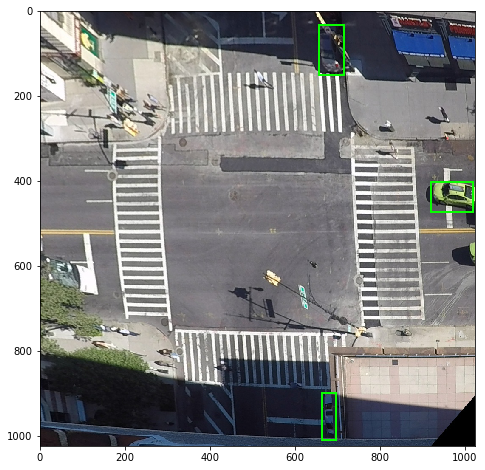

In [59]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img[:,:,::-1])
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

### upsample & downsample

In [7]:
tf.reset_default_graph()
input_ph = tf.placeholder(tf.float32, [None,] + list(input_shape), name="input_image")
gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 16], name="ground_truth")
with tf.variable_scope("ssd_net"):
    ssd_net = SSD()
    feats = ssd_net(input_ph)
    
with tf.variable_scope("up_net"):
    upsample_net = UpSample()
    feats_up, up_factors = upsample_net(feats)
    
with tf.variable_scope("down_net"):
    down_net = DownSample()
    feats_down = down_net(feats_up, up_factors)

In [8]:
feats_up

<tf.Tensor 'up_net/up_feats_concat:0' shape=(?, 48, 48, 3328) dtype=float32>

### similarity

In [34]:
img_path = './data/0247img/'+ "gopr0247frame00002.jpg"
img = cv2.imread(img_path)
img1 = cv2.resize(img, (384, 384)).astype("float32")

img_path = './data/0247img/'+ "gopr0247frame00003.jpg"
img = cv2.imread(img_path)
img2 = cv2.resize(img, (384, 384)).astype("float32")
#eval_input = preprocess_input(img[np.newaxis, :])
#eval_input = eval_input[np.newaxis,:]
#eval_input = img[np.newaxis, :]/255.0

eval_input = np.stack([img1, img2])/255.


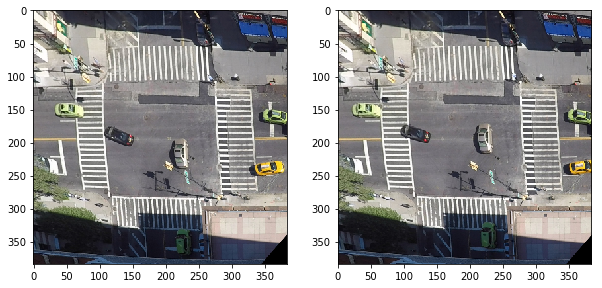

In [35]:
f, axarr = plt.subplots(1,2, figsize=(10,20))
axarr[0].imshow(img1.astype("uint8")[:,:,::-1])
axarr[1].imshow(img2.astype("uint8")[:,:,::-1])

In [36]:
eval_pred = sess.run(predictions, feed_dict={input_ph: eval_input})
results = bbox_util.detection_out(eval_pred)

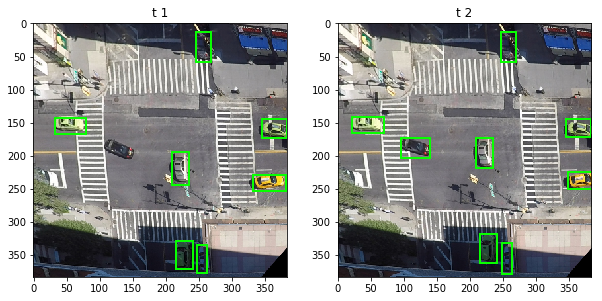

In [68]:
images = [img1, img2]
_, axarr = plt.subplots(1, len(images), figsize=(10,20))
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.25]
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    axarr[i].imshow(img[:,:,::-1].astype("uint8"))
    axarr[i].set_title("t {}".format(i+1))
    #currentAxis = plt.gca()

    for j in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[j] * img.shape[1]))
        ymin = int(round(top_ymin[j] * img.shape[0]))
        xmax = int(round(top_xmax[j] * img.shape[1]))
        ymax = int(round(top_ymax[j] * img.shape[0]))
        score = top_conf[j]
        label = int(top_label_indices[j])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        axarr[i].add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    #plt.show()

In [39]:
eval_feats = sess.run(feats, feed_dict={input_ph: eval_input})

In [51]:
## first feature layer
layer_size = 48
feat48_1 = eval_feats[0][0,:,:,:]
feat48_2 = eval_feats[0][1,:,:,:]

## compare similarity: L2 norm
simx = np.zeros((layer_size,layer_size))
simy = np.zeros((layer_size,layer_size))

conv_size = 5
for i in range(layer_size):
    for j in range(layer_size):
        vec1 = feat48_1[i,j]
        dists = []
        for offx in range(-1*(conv_size//2), conv_size//2+1):
            for offy in range(-1*(conv_size//2), conv_size//2+1):
                oi = i + offx
                oj = j + offy
                if oi>=0 and oi<layer_size and oj>=0 and oj<layer_size:
                    vec2 = feat48_2[oi,oj]
                    dists.append([offx, offy, np.linalg.norm(vec2-vec1)])
        # select out the offx, offy with smallest distance
        simx[i,j], simy[i,j], _ = min(dists, key=lambda d: d[2])

In [45]:
conv_size = 5
for offx in range(-1*(conv_size//2), conv_size//2+1):
    print(offx)

-2
-1
0
1
2


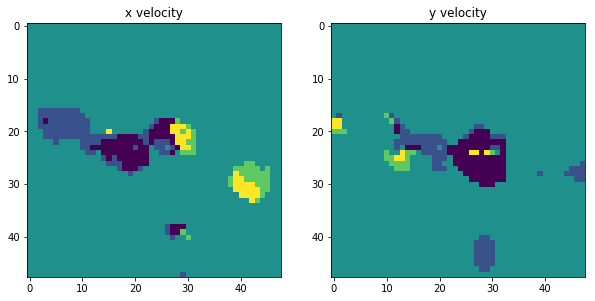

In [65]:
titles = ["x velocity", "y velocity"]
simxy = [simy, simx]
## velocity along columns/rows
_, axarr = plt.subplots(1, len(simxy), figsize=(10, 20))
for i, sim in enumerate(simxy):
    axarr[i].imshow(sim)
    axarr[i].set_title(titles[i])

plt.imshow(simx)

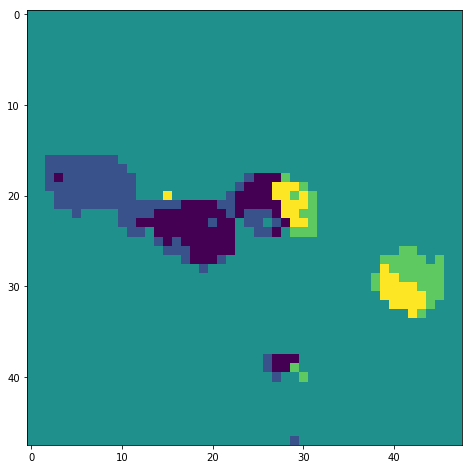

In [53]:
## velocity along the columns
plt.imshow(simy)